## Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression,Lasso

from sklearn.metrics import accuracy_score,precision_score,classification_report
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score
from sklearn.preprocessing import StandardScaler

### Data Collection

In [2]:
# Read the historical data of SPDR S&P 500 ETF Day interval

historical=pd.read_csv("/home/fx/Desktop/Generate_signals/Data Deliverable S&P 500 - Trial 1/S&P 500/SPY with volume.csv")

# make the Date column as index and drop the Date column
historical.index = historical["Date"]
historical=historical.drop(['Date'], axis=1)

In [3]:
historical.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,25.029375,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,25.207382,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,25.260780,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,25.527824,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,25.634628,531500


In [4]:
# lower the column names

historical.columns=historical.columns.str.lower()

In [5]:
# Understand the information of data

historical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7708 entries, 1993-01-29 to 2023-09-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       7708 non-null   float64
 1   high       7708 non-null   float64
 2   low        7708 non-null   float64
 3   close      7708 non-null   float64
 4   adj close  7708 non-null   float64
 5   volume     7708 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 421.5+ KB


In [6]:
# see co- relation of features

historical.corr()

,open,high,low,close,adj close,volume
open,1.000000,0.999935,0.999916,0.999856,0.996703,0.092139
high,0.999935,1.000000,0.999863,0.999910,0.996789,0.094661
low,0.999916,0.999863,1.000000,0.999920,0.996753,0.088657
close,0.999856,0.999910,0.999920,1.000000,0.996856,0.091321
adj close,0.996703,0.996789,0.996753,0.996856,1.000000,0.103406
volume,0.092139,0.094661,0.088657,0.091321,0.103406,1.000000


#### The Approch is use "open ,High ,low, close" Features to prediction

In [7]:
# make dataset with use of open high low and close feature

data = historical[["open","high","low","close"]]
data

,open,high,low,close
Date,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500
1993-02-01,43.968750,44.250000,43.968750,44.250000
1993-02-02,44.218750,44.375000,44.125000,44.343750
1993-02-03,44.406250,44.843750,44.375000,44.812500
1993-02-04,44.968750,45.093750,44.468750,45.000000
...,...,...,...,...
2023-09-01,453.170013,453.670013,449.679993,451.190002
2023-09-05,450.730011,451.059998,449.170013,449.239990
2023-09-06,448.399994,448.510010,443.809998,446.220001


## Split the data into 80 % for train and 20% for test

In [8]:
#Setting The training set ratio
training_ratio = 80

#Calculating the test set ratio
test_ratio = 100-training_ratio

#Rounding the training set length to avoid fractions
training_len = round(len(data)*(training_ratio/100))

#Setting the Test set length
test_len = round(len(data)-training_len)

#Splitting the data based on the calculated lengths
dataset_train = data.head(training_len)
dataset_test = data.tail(test_len)

#Printing the shapes of training and test sets

print("Shape Of Training Set :", dataset_train.shape)
print("Shape Of Test Set :", dataset_test.shape)

Shape Of Training Set : (6166, 4)
Shape Of Test Set : (1542, 4)


#### Input and Output Features

- The data have 1 day interval so we predict the value for each next day 
  so for that we have to make the target column as next day close value 

- Input Features = open , high ,low, close
- output feature(target) = close+1day mark as "new_close"

In [9]:
dataset_train["new_close"]=dataset_train["close"].shift(-1)
dataset_train.dropna(inplace=True)
dataset_train

,open,high,low,close,new_close
Date,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,44.250000
1993-02-01,43.968750,44.250000,43.968750,44.250000,44.343750
1993-02-02,44.218750,44.375000,44.125000,44.343750,44.812500
1993-02-03,44.406250,44.843750,44.375000,44.812500,45.000000
1993-02-04,44.968750,45.093750,44.468750,45.000000,44.968750
...,...,...,...,...,...
2017-07-17,245.470001,245.910004,245.330002,245.529999,245.660004
2017-07-18,245.059998,245.720001,244.669998,245.660004,246.990005
2017-07-19,246.020004,247.000000,246.009995,246.990005,247.100006


In [10]:
# For test we have to predict the value and check the Error rate 

dataset_test

,open,high,low,close
Date,,,,
2017-07-25,247.679993,247.800003,247.160004,247.419998
2017-07-26,247.750000,247.789993,247.130005,247.429993
2017-07-27,247.960007,248.000000,245.679993,247.199997
2017-07-28,246.649994,247.059998,246.130005,246.910004
2017-07-31,247.369995,247.479996,246.529999,246.770004
...,...,...,...,...
2023-09-01,453.170013,453.670013,449.679993,451.190002
2023-09-05,450.730011,451.059998,449.170013,449.239990
2023-09-06,448.399994,448.510010,443.809998,446.220001


In [11]:
# make train data seperate as input feature and output features

x_train= dataset_train.drop("new_close",axis=1)
y_train = dataset_train["new_close"]

### Data having good corelation so we start with Linear Regression model

### Linear Regression

- Linear regression is an algorithm that provides a linear relationship between an independent variable and a dependent variable to predict the outcome of future events. It is a statistical method used in data science and machine learning for predictive analysis.

- The independent variable is also the predictor or explanatory variable that remains unchanged due to the change in other variables. However, the dependent variable changes with fluctuations in the independent variable. The regression model predicts the value of the dependent variable, which is the response or outcome variable being analyzed or studied.

- Thus, linear regression is a supervised learning algorithm that simulates a mathematical relationship between variables and makes predictions for continuous or numeric variables such as sales, salary, age, product price, etc.

- This analysis method is advantageous when at least two variables are available in the data, as observed in stock market forecasting, portfolio management, scientific analysis, etc.

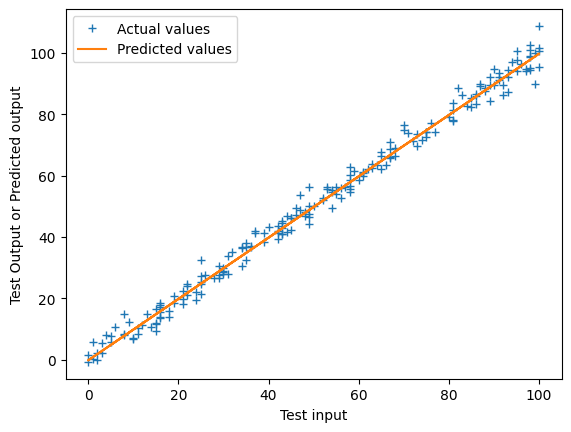

In [12]:
# make an instance of model
lr_model=LinearRegression(n_jobs=-1)

# Train the model
lr_model.fit(x_train,y_train)

LinearRegression(n_jobs=-1)

In [14]:
# # save the model into pkl file

# import pickle

# with open ("model.pkl" ,"wb") as file :
#       pickle.dump(lr_model,file)

In [15]:
# Evaluate on train data
y_pred = lr_model.predict(x_train)

mse=mean_squared_error(y_train,y_pred)
print("mean_squared_error",mse)

mae=mean_absolute_error(y_train,y_pred)
print("mean_absolute_error",mae)

r2= r2_score(y_train,y_pred)
print("r2 score",r2)

#No. of Rows
n=dataset_train.shape[0] 
#Np. of columns
p=dataset_train.shape[0]

adj_r2 =1-((1-r2)*(n-1)/(n-p-1)) 
print("Adjected r2",adj_r2)

mean_squared_error 1.888394211695429
mean_absolute_error 0.9312085501204777
r2 score 0.9991460544468623
Adjected r2 6.263720389540595


In [16]:
# Make output columns for compare with prediction
dataset_test["new_close"]=dataset_test["close"].shift(-1)

In [17]:
dataset_test.dropna(inplace=True)
x_test=dataset_test.drop(["new_close"],axis=1)
y_test=dataset_test["new_close"]

In [18]:
#Evaluate on train data
y_pred = lr_model.predict(x_test)

mse=mean_squared_error(y_test,y_pred)
print("mean_squared_error",mse)

mae=mean_absolute_error(y_test,y_pred)
print("mean_absolute_error",mae)

r2= r2_score(y_test,y_pred)
print("r2 score",r2)

n=dataset_test.shape[0]
p=dataset_test.shape[0]

adj_r2 =1-((1-r2)*(n-1)/(n-p-1)) 
print("Adjected r2",adj_r2)

mean_squared_error 17.45691463949751
mean_absolute_error 2.8448850118105695
r2 score 0.9964241229881757
Adjected r2 6.506850598209374


In [19]:
dataset_test

,open,high,low,close,new_close
Date,,,,,
2017-07-25,247.679993,247.800003,247.160004,247.419998,247.429993
2017-07-26,247.750000,247.789993,247.130005,247.429993,247.199997
2017-07-27,247.960007,248.000000,245.679993,247.199997,246.910004
2017-07-28,246.649994,247.059998,246.130005,246.910004,246.770004
2017-07-31,247.369995,247.479996,246.529999,246.770004,247.320007
...,...,...,...,...,...
2023-08-31,451.649994,452.829987,450.160004,450.350006,451.190002
2023-09-01,453.170013,453.670013,449.679993,451.190002,449.239990
2023-09-05,450.730011,451.059998,449.170013,449.239990,446.220001


In [20]:
# make output dataframe for generate signals and store it

output_data = dataset_test.copy()

In [21]:
# store the output value 

output_data["predicted_value"]=y_pred

In [24]:
output_data

,open,high,low,close,new_close,predicted_value
Date,,,,,,
2017-07-25,247.679993,247.800003,247.160004,247.419998,247.429993,247.395814
2017-07-26,247.750000,247.789993,247.130005,247.429993,247.199997,247.395073
2017-07-27,247.960007,248.000000,245.679993,247.199997,246.910004,247.100188
2017-07-28,246.649994,247.059998,246.130005,246.910004,246.770004,246.844134
2017-07-31,247.369995,247.479996,246.529999,246.770004,247.320007,246.774489
...,...,...,...,...,...,...
2023-08-31,451.649994,452.829987,450.160004,450.350006,451.190002,450.535487
2023-09-01,453.170013,453.670013,449.679993,451.190002,449.239990,451.216575
2023-09-05,450.730011,451.059998,449.170013,449.239990,446.220001,449.319754


In [25]:
def roundup(x):
    return round(x,1)

In [26]:
# round up the values for compare 

output_data["new_close"]=output_data["new_close"].apply(roundup)
output_data["predicted_value"]=output_data["predicted_value"].apply(roundup)

In [27]:
output_data

,open,high,low,close,new_close,predicted_value
Date,,,,,,
2017-07-25,247.679993,247.800003,247.160004,247.419998,247.4,247.4
2017-07-26,247.750000,247.789993,247.130005,247.429993,247.2,247.4
2017-07-27,247.960007,248.000000,245.679993,247.199997,246.9,247.1
2017-07-28,246.649994,247.059998,246.130005,246.910004,246.8,246.8
2017-07-31,247.369995,247.479996,246.529999,246.770004,247.3,246.8
...,...,...,...,...,...,...
2023-08-31,451.649994,452.829987,450.160004,450.350006,451.2,450.5
2023-09-01,453.170013,453.670013,449.679993,451.190002,449.2,451.2
2023-09-05,450.730011,451.059998,449.170013,449.239990,446.2,449.3


In [30]:
# build the function which can generate bullish and bearish signal

def bearish_bullish_signal(op, cl):
    #If new closing price is greater than the opening price, its a bullish signal
  if cl > op:    
    return 1
  #If new closing price is lesser than the opening price, its a Bearish
  else:
    return 0

In [31]:
#Mapping the bearish_bullish_signal method to the actual closing price in the test data and saving it as a column
output_data["signal_actual"] = list(map(bearish_bullish_signal, output_data['open'], output_data['new_close']))

In [34]:
output_data["signal_predicted"] = list(map(bearish_bullish_signal, output_data['open'], output_data['predicted_value']))

In [35]:
output_data

,open,high,low,close,new_close,predicted_value,signal_actual,signal_predicted
Date,,,,,,,,
2017-07-25,247.679993,247.800003,247.160004,247.419998,247.4,247.4,0,0
2017-07-26,247.750000,247.789993,247.130005,247.429993,247.2,247.4,0,0
2017-07-27,247.960007,248.000000,245.679993,247.199997,246.9,247.1,0,0
2017-07-28,246.649994,247.059998,246.130005,246.910004,246.8,246.8,1,1
2017-07-31,247.369995,247.479996,246.529999,246.770004,247.3,246.8,0,0
...,...,...,...,...,...,...,...,...
2023-08-31,451.649994,452.829987,450.160004,450.350006,451.2,450.5,0,0
2023-09-01,453.170013,453.670013,449.679993,451.190002,449.2,451.2,0,0
2023-09-05,450.730011,451.059998,449.170013,449.239990,446.2,449.3,0,0


In [37]:
# Calculate the confustion matrix based on signal output (actual and predicted)

from sklearn.metrics import accuracy_score,confusion_matrix

cm= confusion_matrix(output_data['signal_actual'], output_data['signal_predicted'])
cm

array([[476, 211],
       [237, 617]])

In [40]:
# Finally see the accuracy score for prediction

Accuracy = (cm.diagonal().sum()/cm.sum())*100
print("Bearish_Bullish_signal_Accuracy : ", Accuracy)

Bearish_Bullish_signal_Accuracy :  70.92796885139519
